In [2]:
from cmath import log
import uproot as up
import awkward as ak
import coffea
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema, TreeMakerSchema
from coffea.nanoevents.methods import candidate
ak.behavior.update(candidate.behavior)
from template.temp_class import ntuplize
import numpy as np
import argparse
import os
from utils import common_helper as com
from utils import analyze_helper as ana
from coffea import hist as chist
import yaml

import numba as nb

In [3]:
def Delta_phi(phi1,phi2):
    a = abs(phi1-phi2)
    return np.array(1*(a<=pi)*a+1*(a>pi)*(2*pi-a))

def Delta_eta(eta1,eta2):
    return np.array(abs(eta1-eta2))

def Delta_r(eta1,phi1,eta2,phi2):
    de = Delta_eta(eta1,eta2)
    dp = Delta_phi(phi1,phi2)
    return np.sqrt(de**2+dp**2)

In [4]:
pi = 3.14159265

@nb.jit(nopython=True)
def delta_phi(phi1,phi2):
    a = abs(phi1-phi2)
    return np.array(1*(a<=pi)*a+1*(a>pi)*(2*pi-a))

@nb.jit(nopython=True)
def delta_eta(eta1,eta2):
    return np.array(abs(eta1-eta2))

@nb.jit(nopython=True)
def delta_r(eta1,phi1,eta2,phi2):
    de = delta_eta(eta1,eta2)
    dp = delta_phi(phi1,phi2)
    return np.sqrt(de**2+dp**2)

@nb.jit(nopython=True)
def is_clean_with_collection(pat1, pat2_col, cone_size):
    if len(pat2_col)==0:
        return True
    for pat in pat2_col:
        if not delta_r(pat1.eta, pat1.phi, pat.eta, pat.phi) > cone_size:
            return False
    return True

@nb.jit(nopython=True)
def get_jets_drclean(jets,leptons,cone_size):
    jets_drclean = []
    for i,jets_per_event in enumerate(jets):
        jets_drclean_temp = []
        for jet in jets_per_event:
            jets_drclean_temp.append(is_clean_with_collection(jet, leptons[i], cone_size))
        jets_drclean.append(jets_drclean_temp[:])
    return jets_drclean

Create type 2 hist_plot named "some object".
/data/pubfs/tyyang99/jupyter_files/pkutree/coffea_newid_mc_ssww_parquet/WpWpJJ_LL_polarization_EWK/0/0.parquet 	1/16


/home/pku/tyyang99/anaconda3/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:200: RuntimeWarning: Missing cross-reference target for Electron_photonIdx => Photon
  warnings.warn(
/home/pku/tyyang99/anaconda3/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  warnings.warn(
/home/pku/tyyang99/anaconda3/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/home/pku/tyyang99/anaconda3/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(
/home/pku/tyyang99/anaconda3/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FsrPhoton_muonIdx => Muon
  warnings.warn(
/home/pku/tyyang99/anacon

/data/pubfs/tyyang99/jupyter_files/pkutree/coffea_newid_mc_ssww_parquet/WpWpJJ_LL_polarization_EWK/1/1.parquet 	2/16
/data/pubfs/tyyang99/jupyter_files/pkutree/coffea_newid_mc_ssww_parquet/WpWpJJ_LL_polarization_EWK/2/2.parquet 	3/16
/data/pubfs/tyyang99/jupyter_files/pkutree/coffea_newid_mc_ssww_parquet/WpWpJJ_LL_polarization_EWK/3/3.parquet 	4/16
/data/pubfs/tyyang99/jupyter_files/pkutree/coffea_newid_mc_ssww_parquet/WpWpJJ_LL_polarization_EWK/4/4.parquet 	5/16
/data/pubfs/tyyang99/jupyter_files/pkutree/coffea_newid_mc_ssww_parquet/WpWpJJ_LL_polarization_EWK/5/5.parquet 	6/16
/data/pubfs/tyyang99/jupyter_files/pkutree/coffea_newid_mc_ssww_parquet/WpWpJJ_LL_polarization_EWK/6/6.parquet 	7/16
/data/pubfs/tyyang99/jupyter_files/pkutree/coffea_newid_mc_ssww_parquet/WpWpJJ_LL_polarization_EWK/7/7.parquet 	8/16
/data/pubfs/tyyang99/jupyter_files/pkutree/coffea_newid_mc_ssww_parquet/WpWpJJ_LL_polarization_EWK/8/8.parquet 	9/16
/data/pubfs/tyyang99/jupyter_files/pkutree/coffea_newid_mc_ssww_

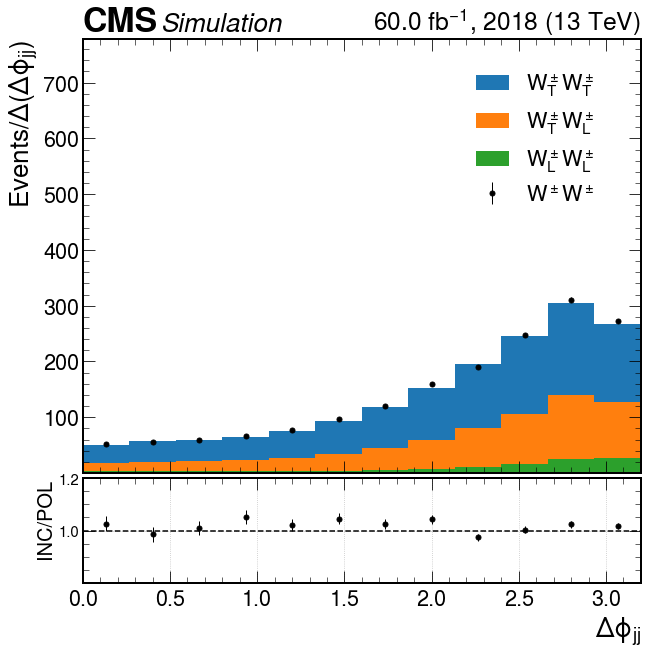

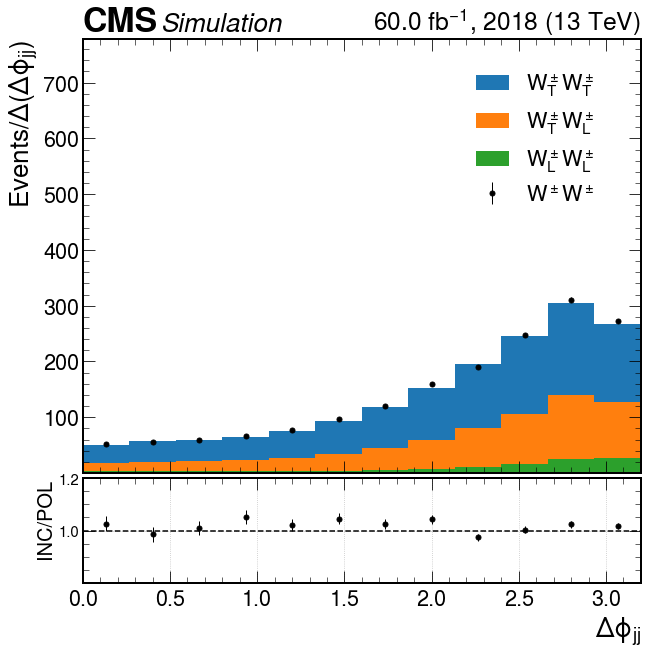

In [11]:
from yty_hist_class import yty_histplot

histbins = np.linspace(0,3.2,12+1)
plot_hist = yty_histplot('some object',2,histbins,Figsize=(10,10))

x_label = '$\\Delta\\phi_{jj}$'
y1_label = '$Events/\\Delta(\\Delta\\phi_{jj})$'
y2_label = 'INC/POL'

Lumi = 60.0*1e3

WW_polar = ['WpWpJJ_LL_polarization_EWK','WpWpJJ_TL_polarization_EWK','WpWpJJ_TT_polarization_EWK','WpWpJJ_EWK']
# WW_polar = ['WpWpJJ_LL_polarization_EWK','WpWpJJ_TL_polarization_EWK','WpWpJJ_TT_polarization_EWK']
legendlist = ['$W^\pm_L W^\pm_L$','$W^\pm_T W^\pm_L$','$W^\pm_T W^\pm_T$','$W^\pm W^\pm$']

isdata = 'mc'
process_dir = f'coffea_newid_{isdata}_ssww_parquet'

pwd = os.popen('pwd').readlines()[0].replace('\n','')

with open(f"/data/pubfs/tyyang99/jupyter_files/changexs_datasets.yaml", 'r') as f:
    mc_yaml = yaml.load(f, Loader=yaml.FullLoader)
    
for i,process in enumerate(WW_polar):
    legend = legendlist[i]
    
    temp_value_list = []
    temp_weight_list = []
    
    abs_process_dir = pwd + '/' + process_dir + '/' + process
    xs = mc_yaml[process]['xs']
    nevents = 0
    if process=='WpWpJJ_EWK':
        factor = (mc_yaml['WpWpJJ_LL_polarization_EWK']['xs']+mc_yaml['WpWpJJ_TL_polarization_EWK']['xs']+mc_yaml['WpWpJJ_TT_polarization_EWK']['xs'])/mc_yaml['WpWpJJ_EWK']['xs']
#         factor = 1.09
    else:
        factor = 1
        
    parquet_list = []
    for num in os.listdir(abs_process_dir):
        parquet_list.append(abs_process_dir+'/%s/%s.parquet'%(num,num))
        
    for n_par, parquet_file in enumerate(parquet_list):
        parquet_dir = parquet_file
        print(parquet_dir,'\t%d/%d'%(n_par+1,len(parquet_list)))
        try:
            events = NanoEventsFactory.from_parquet(parquet_dir, schemaclass=NanoAODSchema).events()
        except:
            continue
        nevents += events.nevents[0]

        muons = events.Muon
        electrons = events.Electron
        taus = events.Tau
        good_jets = events.Jet
        MET = events.MET
        puppimet = events.PuppiMET

        events['nloose_muons'] = np.sum(muons.isloose==1,axis=1)
        events['ntight_muons'] = np.sum(muons.istight==1,axis=1)

        events['nloose_electrons'] = np.sum(electrons.isloose==1,axis=1)
        events['ntight_electrons'] = np.sum(electrons.istight==1,axis=1)

        events['ngood_jets'] = ak.count(good_jets.pt,axis=1)
        
        good_tau_sel1 = (taus.pt > 20) & (abs(taus.eta) < 2.3) & ((taus.decayMode!=5) & (taus.decayMode!=6)) & (taus.idDeepTau2017v2p1VSjet>>2 & 1)
        good_tau_sel2 = (taus.idDeepTau2017v2p1VSe > 16) & (taus.idDeepTau2017v2p1VSjet > 16) & (taus.idDeepTau2017v2p1VSmu > 4)
        good_tau_sel3 = ana.is_clean(taus,muons,0.4) & ana.is_clean(taus,electrons,0.4)
        good_tau_sel = good_tau_sel1 & good_tau_sel2 & good_tau_sel3

        taus['isgood'] = good_tau_sel
        events['ngood_taus'] = np.sum(good_tau_sel,axis=1)
    
        #2lepton and multijets
        nleps_sel = events.nloose_muons+events.nloose_electrons==2
        nveto_leps_sel = events.nveto.muons+events.nveto.electrons==2
        njets_sel = events.ngood_jets>=2
        tau_veto_sel = events.ngood_taus==0
        _2lnj_sel = nleps_sel & nveto_leps_sel & njets_sel & tau_veto_sel
    
        #get selected objects
        sel_events = events[_2lnj_sel]
        sel_electrons = electrons[electrons.isloose==1][_2lnj_sel]
        sel_muons = muons[muons.isloose==1][_2lnj_sel]
        sel_leptons = ak.concatenate([sel_electrons,sel_muons],axis=1)
        sel_jets = good_jets[_2lnj_sel]

        #get 1e1mu, 2e, 2mu
        _2e_sel = (sel_events.nloose_electrons==2)
        _2m_sel = (sel_events.nloose_muons==2)
        _1e1mu_sel = (sel_events.nloose_electrons==1) & (sel_events.nloose_muons==1)

        #HLT for 1e1mu, 2e, 2mu
        if isdata=='mc':
            HLT_list_pass = ['Mu12_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ',
                        'Mu12_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL',
                        'Mu23_TrkIsoVVL_Ele12_CaloIdL_TrackIdL_IsoVL_DZ',
                        'Mu23_TrkIsoVVL_Ele12_CaloIdL_TrackIdL_IsoVL',
                        'Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ',
                        'Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL',
                        'Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8',
                        'Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass8',
                        'Mu19_TrkIsoVVL_Mu9_TrkIsoVVL_DZ_Mass3p8',
                        'Mu19_TrkIsoVVL_Mu9_TrkIsoVVL_DZ_Mass8',
                        'Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ',
                        'Ele23_Ele12_CaloIdL_TrackIdL_IsoVL',
                        'DiEle27_WPTightCaloOnly_L1DoubleEG',
                        'DoubleEle33_CaloIdL_MW',
                        'DoubleEle25_CaloIdL_MW',
                        'DoubleEle27_CaloIdL_MW',
                        'DoublePhoton70',
                        'IsoMu24','IsoMu27','IsoMu30','Mu50',
                        'Ele115_CaloIdVT_GsfTrkIdT',
                        'Ele27_WPTight_Gsf',
                        'Ele28_WPTight_Gsf',
                        'Ele32_WPTight_Gsf',
                        'Ele35_WPTight_Gsf',
                        'Ele38_WPTight_Gsf',
                        'Ele40_WPTight_Gsf',
                        'Ele32_WPTight_Gsf_L1DoubleEG',
                        'Photon200']
            HLT_list_fail = []
        HLT_sel_pass = 0*ak.ones_like(sel_events.nloose_muons)==1
        HLT_sel_fail = 0*ak.ones_like(sel_events.nloose_muons)==1
        for field in HLT_list_pass:
            try:
                HLT_sel_pass = HLT_sel_pass | sel_events.HLT[field]
            except:
                pass
        for field in HLT_list_fail:
            try:
                HLT_sel_fail = HLT_sel_fail | sel_events.HLT[field]
            except:
                pass
        HLT_sel = HLT_sel_pass & (1-HLT_sel_fail)
        
        all_filter = (HLT_sel==1)
        
        leading_jet = sel_jets[ak.argsort(sel_jets.pt,axis=1,ascending=False)==0]
        subleading_jet = sel_jets[ak.argsort(sel_jets.pt,axis=1,ascending=False)==1]
        
        delta_phi_ll = Delta_phi(sel_leptons[:,0].phi,sel_leptons[:,1].phi)
        delta_phi_jj = Delta_phi(leading_jet.phi,subleading_jet.phi)[:,0]
        
        temp_value_list.append(delta_phi_jj[all_filter])
        temp_weight_list.append(sel_events.Generator.weight[all_filter])
        
    mc_weight = Lumi*xs/nevents
    
    plot_hist.append_values(legend,temp_value_list)
    plot_hist.append_weights(legend,[factor*mc_weight*ak.concatenate(temp_weight_list)])
    
    
plot_hist.set_legend(legendbool=True,ncol=1)
plot_hist.set_autoylim(2.5)
plot_hist.set_title(Lumi=60.0, Year=2018, xlabel=x_label, y1label=y1_label, y2label=y2_label,title='',cmstitle=True)
plot_hist.draw(legendlist[:-1][:],histtype_list = ['fill']*len(legendlist[:-1][:]),stack=True)
plot_hist.draw(legendlist[-1],histtype_list = ['errorbar'],color_list = ['black'])
plot_hist.compare('$W^\pm W^\pm$','$W^\pm_T W^\pm_T$',stack2=True,ylim=[0.8,1.2])

In [8]:
delta_phi_jj

array([1.28503418, 2.69082642, 2.05603027, ..., 1.16064453, 2.7358222 ,
       2.75283813])